<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Web Scraping Job Postings

Done by: Darren Siow

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

1. Determine the industry factors that are most important in predicting the salary amounts for these data.
2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

**QUESTION 1: Factors that impact salary**

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary). You have learned a variety of new skills and models that may be useful for this problem: NLP Unsupervised learning and dimensionality reduction techniques (PCA, clustering) Ensemble methods and decision tree models SVM models Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

**QUESTION 2: Factors that distinguish job category**
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

## Section 1: Loading of data sets

The job data have been scraped from www.mycareersfuture.sg and stored in several csv files.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the separate csvs into different dataframes

df_AI = pd.read_csv('careersfuture_AI.csv', index_col = 0)
df_biz_intel = pd.read_csv('careersfuture_business_intel.csv', index_col = 0)
df_DA = pd.read_csv('careersfuture_data_analyst.csv', index_col = 0)
df_DE_1 = pd.read_csv('careersfuture_data_engineer_part1.csv', index_col = 0)
df_DE_2 = pd.read_csv('careersfuture_data_engineer_part2.csv', index_col = 0)
df_DS = pd.read_csv('careersfuture_data_scientist.csv', index_col = 0)
df_ML_1 = pd.read_csv('careersfuture_ML_part1.csv', index_col = 0)
df_ML_2 = pd.read_csv('careersfuture_ML_part2.csv', index_col = 0)
df_stats = pd.read_csv('careersfuture_statistician.csv', index_col = 0)

In [3]:
# Combining the separate dataframes into one big dataframe

frames = [df_AI, df_biz_intel, df_DA, df_DE_1, df_DE_2, df_DS, df_ML_1, df_ML_2, df_stats]
df = pd.concat(frames)
df.reset_index(inplace =True)

## Section 2:  Data Cleaning

### 2.1 Remove duplicate job postings

In [4]:
# Identifying and removing duplicates from the dataset

print('The dimensions of the dataset before:',df.shape)
df = df.drop_duplicates(['title','company','employment_type','job_level'], keep="first")
df.reset_index(drop=True,inplace=True)
print('The dimensions of the dataset after:',df.shape)

The dimensions of the dataset before: (906, 10)
The dimensions of the dataset after: (629, 10)


In [5]:
df.head(2)

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements
0,Principal Engineer (Research),SP CAPITAL LIMITED,Contract,Professional,Engineering,5000.0,8000.0,Monthly,"What you'll do: Conduct evaluation, research ...","What you'll do: Conduct evaluation, research ..."
1,Cloud Engineer (Apprenticeship),IBM SINGAPORE PTE LTD,Full Time,Fresh/entry level,Information Technology,2400.0,2600.0,Monthly,IBM is the largest technology and consulting e...,IBM is the largest technology and consulting e...


### 2.2 Dropping rows with missing salary information

In [6]:
# Missing salary information
salary_nan = df.loc[df[pd.isnull(df['salary_lower'])].index, :]
print('There are {} rows with missing salary information'.format(len(salary_nan)))

# Dropping the rows with missing salary information
print('The dimensions of the dataset before:',df.shape)
df = df.drop(salary_nan.index)
df.reset_index(drop=True,inplace=True)
print('The dimensions of the dataset after:',df.shape)

There are 51 rows with missing salary information
The dimensions of the dataset before: (629, 10)
The dimensions of the dataset after: (578, 10)


### 2.3 Aligning all salaries to be monthly

While most salary information is provided monthly, some salaries are provided annually.

In [7]:
df['salary_time_interval'].value_counts() # 554 are monthly, 24 are annually.

Monthly     554
Annually     24
Name: salary_time_interval, dtype: int64

#### 2.3.1 Ensuring that salary information is correct

There could be a possibility that salary information is entered wrongly.

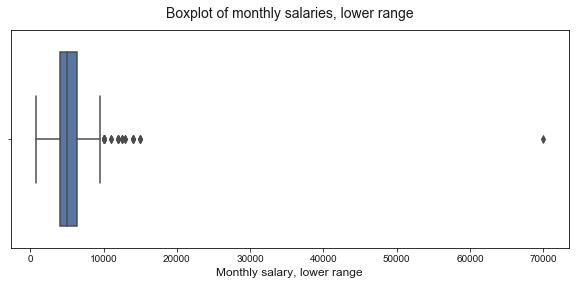

In [8]:
# Examining the monthly salaries
df_monthly = df.loc[df[df['salary_time_interval'] == 'Monthly'].index,:]

fig, ax = plt.subplots(figsize=(10,4))
sns.set(style="whitegrid")
sns.boxplot(x=df_monthly['salary_lower'], ax = ax)
ax.set_xlabel('Monthly salary, lower range', fontsize = 12)
ax.set_title('Boxplot of monthly salaries, lower range', fontsize = 14, y=1.03)
plt.show()

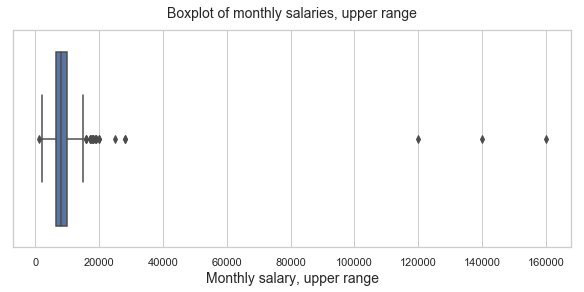

In [9]:
# Examining the monthly salaries
fig, ax = plt.subplots(figsize=(10,4))
sns.set(style="whitegrid")
sns.boxplot(x=df_monthly['salary_upper'], ax = ax)
ax.set_xlabel('Monthly salary, upper range', fontsize = 14)
ax.set_title('Boxplot of monthly salaries, upper range', fontsize = 14, y=1.03)
plt.show()

In [10]:
# Inspecting the extreme salaries

df_monthly.loc[df_monthly[df_monthly['salary_lower'] > 10000].index,:]

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements
60,Asia Pacific Communications Lead,LENOVO ENTERPRISE SOLUTIONS (SINGAPORE) PTE. LTD.,Full Time,Manager,"Information Technology, Marketing / Public Rel...",12000.0,14500.0,Monthly,Lenovo is a US $43 billion global Fortune 500 ...,Lenovo is a US $43 billion global Fortune 500 ...
65,APAC Regional Marketing Manager,ELEMENT AI INC. PTE. LTD.,"Permanent, Full Time",Manager,Marketing / Public Relations,12500.0,17500.0,Monthly,APAC Regional Marketing Manager - Singapore El...,APAC Regional Marketing Manager - Singapore El...
91,Partner - Compensation and People Sciences,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Permanent,Manager,Human Resources,11000.0,15000.0,Monthly,Does the challenge and ownership that comes fr...,Does the challenge and ownership that comes fr...
154,Regional Data Quality Lead,HEINEKEN ASIA PACIFIC PTE. LTD.,Full Time,Manager,Others,13000.0,15000.0,Monthly,Global Information Services (GIS) has a worldw...,Global Information Services (GIS) has a worldw...
167,Director of Sales,LIE XIAN PTE. LTD.,Full Time,"Senior Management, Middle Management, Manager,...","Consulting , Information Technology",11000.0,13000.0,Monthly,This is a Big Data and Modern Business Intelli...,This is a Big Data and Modern Business Intelli...
185,Senior Oil Markets Analyst – Energy trading,KERRY CONSULTING PTE. LTD.,"Permanent, Full Time",Senior Management,Accounting / Auditing / Taxation,12000.0,15000.0,Monthly,"- Across the barrel coverage (Crude, light end...","- Across the barrel coverage (Crude, light end..."
194,Business Intelligence Finance Senior Analyst ...,KERRY CONSULTING PTE. LTD.,"Permanent, Full Time",Manager,Accounting / Auditing / Taxation,70000.0,120000.0,Monthly,- Established Industry Leader - Newly Created ...,- Established Industry Leader - Newly Created ...
316,"Vice President, Data Engineering",LAZADA SERVICES SOUTH EAST ASIA PTE. LTD.,Permanent,"Senior Management, Middle Management","Information Technology, Logistics / Supply Chain",13000.0,17000.0,Monthly,"Story of Lazada Group: Launched in 2012, Lazad...","Story of Lazada Group: Launched in 2012, Lazad..."
426,SENIOR DATA SCIENTIST,SIEMENS PTE. LTD.,Full Time,Professional,Information Technology,15000.0,19000.0,Monthly,Collaborate with Product Owners to develop a ...,Collaborate with Product Owners to develop a ...
441,Data Scientist,EXIGER SINGAPORE PTE. LTD.,"Permanent, Full Time",Professional,"Information Technology, Professional Services",12000.0,160000.0,Monthly,Position Summary We are looking for a resource...,Position Summary We are looking for a resource...


In [11]:
df_monthly.loc[df_monthly[df_monthly['salary_upper'] > 20000].index,:]

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements
104,Data Team Lead,MONEYSMART SINGAPORE PTE. LTD.,Permanent,Manager,Information Technology,8000.0,140000.0,Monthly,About the job Moneysmart is hiring a Data Team...,About the job Moneysmart is hiring a Data Team...
194,Business Intelligence Finance Senior Analyst ...,KERRY CONSULTING PTE. LTD.,"Permanent, Full Time",Manager,Accounting / Auditing / Taxation,70000.0,120000.0,Monthly,- Established Industry Leader - Newly Created ...,- Established Industry Leader - Newly Created ...
441,Data Scientist,EXIGER SINGAPORE PTE. LTD.,"Permanent, Full Time",Professional,"Information Technology, Professional Services",12000.0,160000.0,Monthly,Position Summary We are looking for a resource...,Position Summary We are looking for a resource...
512,Head of Integrated Campaigns and Strategic Eve...,GOOGLE ASIA PACIFIC PTE. LTD.,Full Time,Senior Management,Marketing / Public Relations,14045.0,28090.0,Monthly,Company overview: Google is not a conventional...,Company overview: Google is not a conventional...
553,Senior Manager,ORBIUM PTE. LTD.,Permanent,Senior Executive,Consulting,15000.0,25000.0,Monthly,Support the growth of our management consulti...,Support the growth of our management consulti...
570,"Customer Reference Marketing Manager JAPAC, Go...",GOOGLE ASIA PACIFIC PTE. LTD.,Full Time,Manager,Marketing / Public Relations,14000.0,28000.0,Monthly,Company overview: Google is not a conventional...,Company overview: Google is not a conventional...


In [12]:
# The salaries in salary_upper in row indices 104, 441 are likely to be overinflated 10 times - they are corrected accordingly
df.loc[[104,441],'salary_upper'] = df.loc[[104,441],'salary_upper'].map(lambda x: x/10)

In [13]:
# The salary time interval in salary_upper in row index 194 will be changed from monthly to annually
df.loc[[194],'salary_time_interval'] = 'Annually'

In [14]:
# Checking that the changes made are effected
df.loc[[104,194,441],:]

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements
104,Data Team Lead,MONEYSMART SINGAPORE PTE. LTD.,Permanent,Manager,Information Technology,8000.0,14000.0,Monthly,About the job Moneysmart is hiring a Data Team...,About the job Moneysmart is hiring a Data Team...
194,Business Intelligence Finance Senior Analyst ...,KERRY CONSULTING PTE. LTD.,"Permanent, Full Time",Manager,Accounting / Auditing / Taxation,70000.0,120000.0,Annually,- Established Industry Leader - Newly Created ...,- Established Industry Leader - Newly Created ...
441,Data Scientist,EXIGER SINGAPORE PTE. LTD.,"Permanent, Full Time",Professional,"Information Technology, Professional Services",12000.0,16000.0,Monthly,Position Summary We are looking for a resource...,Position Summary We are looking for a resource...


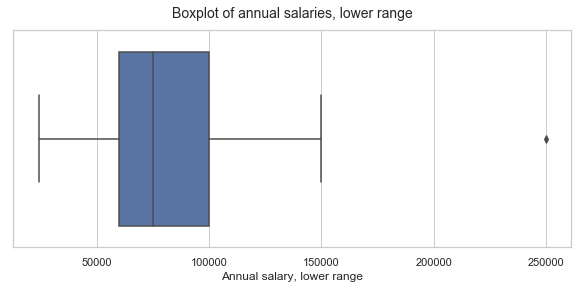

In [15]:
# Examining the annual salaries
df_annual = df.loc[df[df['salary_time_interval'] == 'Annually'].index,:]

fig, ax = plt.subplots(figsize=(10,4))
sns.set(style="whitegrid")
sns.boxplot(x=df_annual['salary_lower'], ax = ax)
ax.set_xlabel('Annual salary, lower range', fontsize = 12)
ax.set_title('Boxplot of annual salaries, lower range', fontsize = 14, y=1.03)
plt.show()

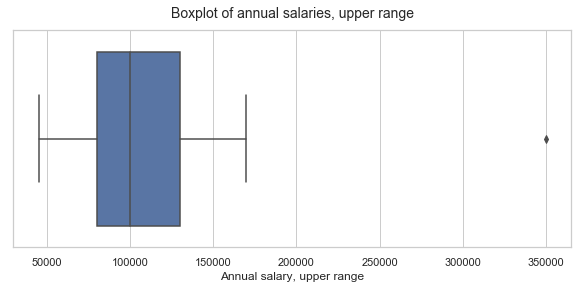

In [16]:
# Examining the annual salaries
fig, ax = plt.subplots(figsize=(10,4))
sns.set(style="whitegrid")
sns.boxplot(x=df_annual['salary_upper'], ax = ax)
ax.set_xlabel('Annual salary, upper range', fontsize = 12)
ax.set_title('Boxplot of annual salaries, upper range', fontsize = 14, y=1.03)
plt.show()

In [17]:
# Inspecting the extreme salary

df_annual.loc[df_annual[df_annual['salary_lower'] > 200000].index,:] 

#It appears that this is an outlier. We will drop this row from the dataset

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements
56,Senior Data Scientist,AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED,Permanent,Professional,Information Technology,250000.0,350000.0,Annually,Excited by using massive amounts of data to de...,Excited by using massive amounts of data to de...


In [18]:
# Dropping index = 56 from df

df.drop(56, axis=0, inplace = True)
df.reset_index(drop=True,inplace=True)

#### 2.3.2 Converting annual salaries to monthly salaries

In [19]:
# Applying function to convert annual salaries to monthly salaries
df.loc[df[df['salary_time_interval'] == 'Annually'].index,'salary_lower'] = df.loc[df[df['salary_time_interval'] == 'Annually'].index,:]['salary_lower'].apply(lambda x: x/12)
df.loc[df[df['salary_time_interval'] == 'Annually'].index,'salary_upper'] = df.loc[df[df['salary_time_interval'] == 'Annually'].index,:]['salary_upper'].apply(lambda x: x/12)

#### 2.3.3 Creating new column - 'avg_salary'

In [20]:
# Create a new column that contains the mean salary (mean salary = mean of salary_lower + salary_upper)
df['avg_salary'] = (df['salary_lower'] + df['salary_upper'])/2

In [21]:
df.loc[df[df['salary_time_interval'] == 'Annually'].index,:]

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements,avg_salary
18,Software Developer,OUTSYSTEMS SINGAPORE PTE. LTD.,Permanent,Junior Executive,Information Technology,3333.333333,4166.666667,Annually,"Job description, low-code style: As the #1 low...","Job description, low-code style: As the #1 low...",3750.000000
46,"Senior Lecturer, University",NATIONAL UNIVERSITY OF SINGAPORE,Full Time,Professional,Education and Training,7000.000000,10500.000000,Annually,The Department of Communications and New Media...,The Department of Communications and New Media...,8750.000000
48,"Lecturer, University",NATIONAL UNIVERSITY OF SINGAPORE,Full Time,Professional,Education and Training,5500.000000,8250.000000,Annually,The Department of Communications and New Media...,The Department of Communications and New Media...,6875.000000
53,Academic Instructor,NATIONAL UNIVERSITY OF SINGAPORE,Full Time,Professional,Education and Training,4166.666667,6250.000000,Annually,The Department of Communications and New Media...,The Department of Communications and New Media...,5208.333333
106,"Business Development Manager, APAC – Energy P...",GLOBALDATA PTE. LTD.,Full Time,Senior Executive,Sales / Retail,5833.333333,6666.666667,Annually,"GlobalData, is a business intelligence company...","GlobalData, is a business intelligence company...",6250.000000
122,"Manager, Artist and Label Marketing - Philippines",SPOTIFY SINGAPORE PTE. LTD.,Permanent,Manager,Others,8333.333333,10833.333333,Annually,The Artist & Label Marketing team manages hund...,The Artist & Label Marketing team manages hund...,9583.333333
123,"Manager, Artist and Label Services - Indonesia",SPOTIFY SINGAPORE PTE. LTD.,Permanent,Manager,Others,8333.333333,10833.333333,Annually,The Artist & Label Marketing Manager will focu...,The Artist & Label Marketing Manager will focu...,9583.333333
132,"Manager, Artist & Label Marketing",SPOTIFY SINGAPORE PTE. LTD.,Permanent,Senior Executive,Marketing / Public Relations,8333.333333,10833.333333,Annually,The Artist & Label Marketing team manages hund...,The Artist & Label Marketing team manages hund...,9583.333333
133,Project Manager,Company Undisclosed,Permanent,Manager,Information Technology,7500.000000,8333.333333,Annually,"Develop, track and report status of detailed p...","Develop, track and report status of detailed p...",7916.666667
147,Senior Developer - Microstrategy,Company Undisclosed,Full Time,Professional,Information Technology,6750.000000,7500.000000,Annually,MicroStrategy – Sr. Developer InfoCepts is a l...,MicroStrategy – Sr. Developer InfoCepts is a l...,7125.000000


#### 2.3.4 Creating new column - 'high_salary'

high_salary column contains 1 if avg_salary is higher than the median salary, and 0 if lower than the median salary.

In [22]:
# Obtaining the median salary of avg_salary column

median_salary = np.median(df['avg_salary'])

C:\Users\USER-PC\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


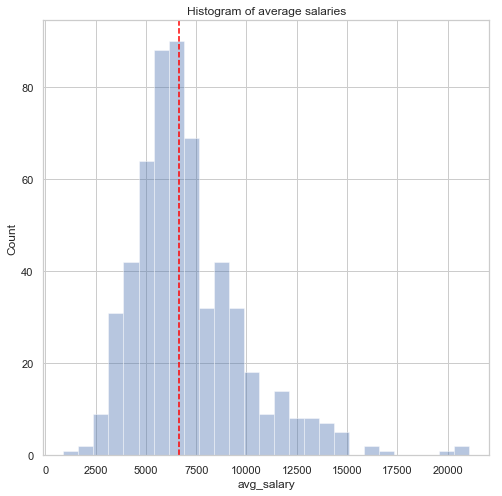

In [23]:
# Visualizing the histogram of avg_salary
# Dotted red line represents the median salary

fig, ax = plt.subplots(figsize = (8,8))
sns.distplot(df['avg_salary'], kde = False, ax = ax)
ax.set_ylabel('Count')
ax.set_title('Histogram of average salaries')
ax.axvline(median_salary, ls='dashed', color='red')

plt.show()

In [24]:
df['high_salary'] = df['avg_salary'].map(lambda x: 1 if x>median_salary else 0)

In [25]:
df.head()

,title,company,employment_type,job_level,category,salary_lower,salary_upper,salary_time_interval,roles,requirements,avg_salary,high_salary
0,Principal Engineer (Research),SP CAPITAL LIMITED,Contract,Professional,Engineering,5000.0,8000.0,Monthly,"What you'll do: Conduct evaluation, research ...","What you'll do: Conduct evaluation, research ...",6500.0,0
1,Cloud Engineer (Apprenticeship),IBM SINGAPORE PTE LTD,Full Time,Fresh/entry level,Information Technology,2400.0,2600.0,Monthly,IBM is the largest technology and consulting e...,IBM is the largest technology and consulting e...,2500.0,0
2,AI Operation Research Scientist,Company Undisclosed,Full Time,Professional,Information Technology,7000.0,12000.0,Monthly,We seek candidates with Constraint Programming...,We seek candidates with Constraint Programming...,9500.0,1
3,Project Officer,NANYANG TECHNOLOGICAL UNIVERSITY,"Contract, Full Time",Professional,Sciences / Laboratory / R&D,2800.0,4000.0,Monthly,The Delta-NTU Corporate Laboratory for Cyber-P...,The Delta-NTU Corporate Laboratory for Cyber-P...,3400.0,0
4,Research Fellow,NANYANG TECHNOLOGICAL UNIVERSITY,"Contract, Full Time",Professional,Sciences / Laboratory / R&D,4500.0,6500.0,Monthly,The Delta-NTU Corporate Laboratory for Cyber-P...,The Delta-NTU Corporate Laboratory for Cyber-P...,5500.0,0


## 2.4 Dropping redundant columns

- Since all salaries are now in monthly, we can drop salary_time_interval.
- salary_lower, salary_upper, and avg_salary will be dropped since we have the high_salary column is calculated.
- roles will also be dropped since it is a duplicate of requirements


In [26]:
df.drop(['salary_lower','salary_upper','avg_salary','salary_time_interval', 'roles'], axis = 1, inplace = True)

In [27]:
df.head()

,title,company,employment_type,job_level,category,requirements,high_salary
0,Principal Engineer (Research),SP CAPITAL LIMITED,Contract,Professional,Engineering,"What you'll do: Conduct evaluation, research ...",0
1,Cloud Engineer (Apprenticeship),IBM SINGAPORE PTE LTD,Full Time,Fresh/entry level,Information Technology,IBM is the largest technology and consulting e...,0
2,AI Operation Research Scientist,Company Undisclosed,Full Time,Professional,Information Technology,We seek candidates with Constraint Programming...,1
3,Project Officer,NANYANG TECHNOLOGICAL UNIVERSITY,"Contract, Full Time",Professional,Sciences / Laboratory / R&D,The Delta-NTU Corporate Laboratory for Cyber-P...,0
4,Research Fellow,NANYANG TECHNOLOGICAL UNIVERSITY,"Contract, Full Time",Professional,Sciences / Laboratory / R&D,The Delta-NTU Corporate Laboratory for Cyber-P...,0


## 2.5 Dropping rows with no requirement information

In [28]:
df.drop(df[df['requirements'].isnull()].index, axis = 0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 7 columns):
title              568 non-null object
company            568 non-null object
employment_type    568 non-null object
job_level          568 non-null object
category           568 non-null object
requirements       568 non-null object
high_salary        568 non-null int64
dtypes: int64(1), object(6)
memory usage: 31.1+ KB


In [30]:
df.loc[df[df.job_level.isnull()].index,:]

,title,company,employment_type,job_level,category,requirements,high_salary


## 2.6 Employment Type - Manual Dummy Coding

In [31]:
df['employment_type'].value_counts()

Full Time                           189
Permanent                           118
Permanent, Full Time                107
Contract, Full Time                  79
Contract                             56
Permanent, Contract, Full Time        8
Permanent, Contract                   5
Temporary, Contract                   1
Full Time, Internship                 1
Permanent, Contract, Internship       1
Contract, Full Time, Internship       1
Internship                            1
Freelance, Full Time, Flexi work      1
Name: employment_type, dtype: int64

In [32]:
x = df['employment_type'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
employment_dummies = pd.get_dummies(x).groupby(level=0).sum()
employment_dummies

,Contract,Flexi work,Freelance,Full Time,Internship,Permanent,Temporary
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,1,0,0,1,0,0,0
4,1,0,0,1,0,0,0
5,1,0,0,1,0,0,0
6,0,0,0,1,0,0,0
7,1,0,0,1,0,0,0
8,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0


## 2.7 Category - Manual Dummy Coding

In [33]:
df['category'].value_counts()

Information Technology                                                                          264
Sciences / Laboratory / R&D                                                                      52
Banking and Finance                                                                              49
Engineering                                                                                      30
Engineering, Information Technology                                                              20
Others                                                                                           17
Engineering, Manufacturing                                                                       12
Consulting                                                                                       11
Banking and Finance, Information Technology                                                       8
Healthcare / Pharmaceutical                                                                       8


In [34]:
y = df['category'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
category_dummies = pd.get_dummies(y).groupby(level=0).sum()
category_dummies

,Accounting / Auditing / Taxation,Advertising / Media,Banking and Finance,Consulting,Customer Service,Design,Education and Training,Engineering,Events / Promotions,General Management,...,Others,Professional Services,Real Estate / Property Management,Repair and Maintenance,Risk Management,Sales / Retail,Sciences / Laboratory / R&D,Social Services,Telecommunications,Travel / Tourism
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cleaning the 'requirements' column

- Removing special characters
- Lower-casing all characters

In [99]:
df['requirements'] = df['requirements'].map(lambda x: ''.join([letter.lower() for letter in x if letter.isalnum() or letter==' ']))

# Section 3: Random Forest Model

- First case: Using only employment type to predict salary
- Second case: Using only category to predict salary
- Third case: Using employment type and category to predict salary
- Fourth case: Using countvectorizer of requirements to predict salary


## 3.1 Using employment type to predict salary

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [74]:
X = employment_dummies
y = df['high_salary'].values

In [75]:
# Splitting our dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [76]:
rfc = RandomForestClassifier(n_estimators=300, random_state=1)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X, y, cv=10, n_jobs=-1)
print("Cross Validation Score:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

print("The confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score: 0.62
Cross Validation Score:	0.555 ± 0.051
The confusion matrix: 
 [[59 25]
 [40 47]]
             precision    recall  f1-score   support

          0       0.60      0.70      0.64        84
          1       0.65      0.54      0.59        87

avg / total       0.62      0.62      0.62       171



In [77]:
# Feature importance
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
5,Permanent,0.272750
0,Contract,0.236577
3,Full Time,0.215731
4,Internship,0.113011
6,Temporary,0.083050
1,Flexi work,0.043088
2,Freelance,0.035795


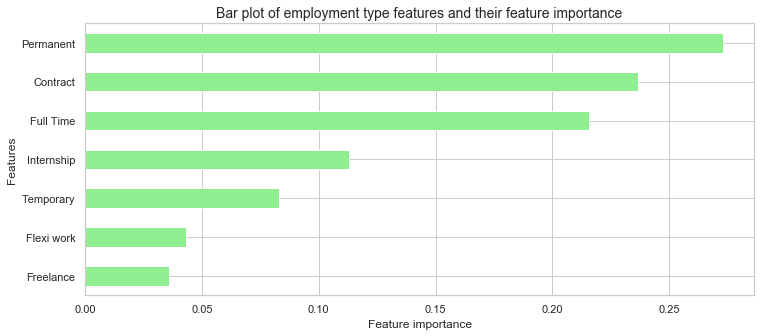

In [78]:
# Visualizing feature importance in a bar graph

fig, ax = plt.subplots(figsize = (12,5))
importance_rfc = pd.Series(rfc.feature_importances_, index=X.columns)
sorted_importance_rfc = importance_rfc.sort_values()
ax = sorted_importance_rfc.plot(kind = 'barh', color = 'lightgreen')
ax.set_xlabel('Feature importance')
ax.set_ylabel('Features')
ax.set_title('Bar plot of employment type features and their feature importance', fontsize = 14)
plt.show()

## 3.2 Using category to predict salary

In [79]:
X = category_dummies
y = df['high_salary'].values

In [80]:
# Splitting our dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [81]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X, y, cv=10, n_jobs=-1)
print("Cross Validation Score:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

print("The confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score: 0.556
Cross Validation Score:	0.52 ± 0.071
The confusion matrix: 
 [[24 60]
 [16 71]]
             precision    recall  f1-score   support

          0       0.60      0.29      0.39        84
          1       0.54      0.82      0.65        87

avg / total       0.57      0.56      0.52       171



In [82]:
# Feature importance
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
13,Information Technology,0.143157
7,Engineering,0.096639
2,Banking and Finance,0.091696
3,Consulting,0.071969
18,Others,0.055329
24,Sciences / Laboratory / R&D,0.052093
17,Marketing / Public Relations,0.047619
19,Professional Services,0.046620
16,Manufacturing,0.042567
15,Logistics / Supply Chain,0.037759


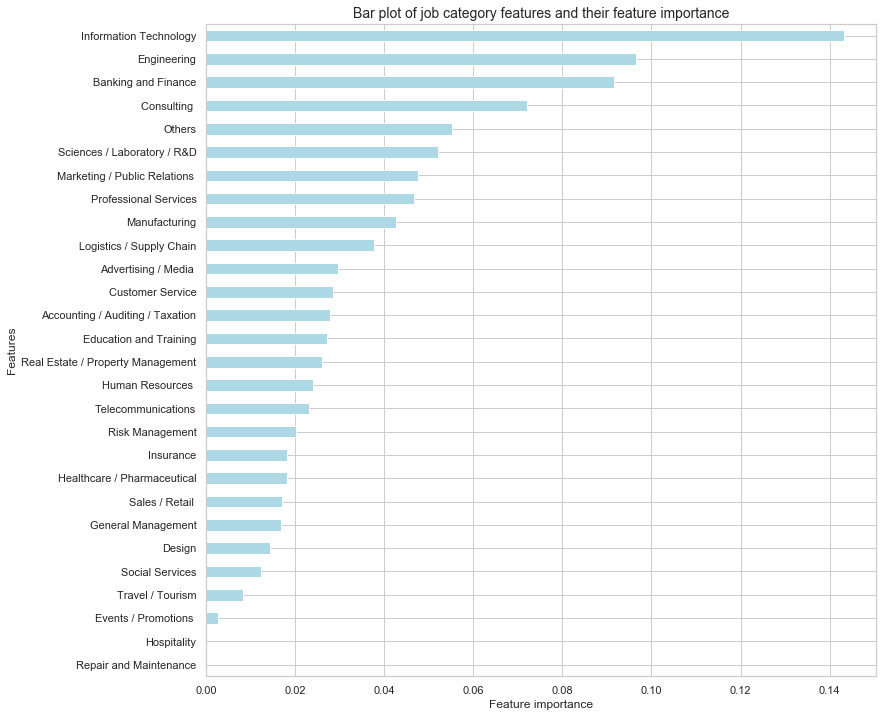

In [83]:
# Visualizing feature importance in a bar graph

fig, ax = plt.subplots(figsize = (12,12))
importance_rfc = pd.Series(rfc.feature_importances_, index=X.columns)
sorted_importance_rfc = importance_rfc.sort_values()
ax = sorted_importance_rfc.plot(kind = 'barh', color = 'lightblue')
ax.set_xlabel('Feature importance')
ax.set_ylabel('Features')
ax.set_title('Bar plot of job category features and their feature importance', fontsize = 14)
plt.show()

## 3.3 Using employment type and category to predict salary

In [84]:
X = pd.concat([employment_dummies, category_dummies],axis=1)
y = df['high_salary'].values

In [85]:
# Splitting our dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [86]:
rfc = RandomForestClassifier(n_estimators=400, random_state=1)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X, y, cv=10, n_jobs=-1)
print("Cross Validation Score:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

print("The confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score: 0.614
Cross Validation Score:	0.571 ± 0.071
The confusion matrix: 
 [[49 35]
 [31 56]]
             precision    recall  f1-score   support

          0       0.61      0.58      0.60        84
          1       0.62      0.64      0.63        87

avg / total       0.61      0.61      0.61       171



In [87]:
# Feature importance
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
20,Information Technology,0.105166
14,Engineering,0.091675
0,Contract,0.087877
3,Full Time,0.087385
5,Permanent,0.078472
9,Banking and Finance,0.076675
10,Consulting,0.053321
25,Others,0.046088
31,Sciences / Laboratory / R&D,0.037781
24,Marketing / Public Relations,0.036737


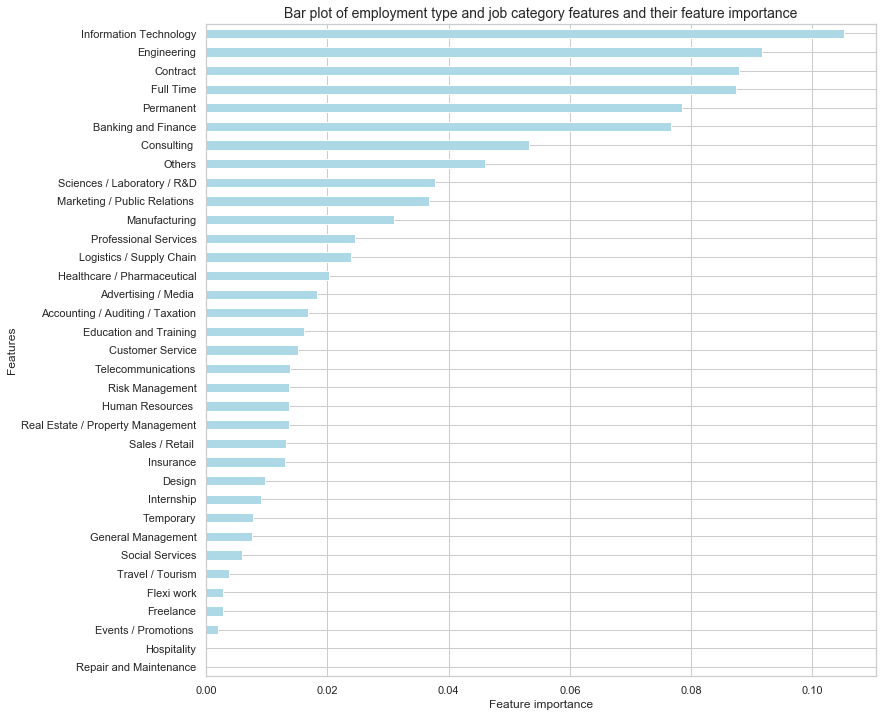

In [88]:
# Visualizing feature importance in a bar graph

fig, ax = plt.subplots(figsize = (12,12))
importance_rfc = pd.Series(rfc.feature_importances_, index=X.columns)
sorted_importance_rfc = importance_rfc.sort_values()
ax = sorted_importance_rfc.plot(kind = 'barh', color = 'lightred')
ax.set_xlabel('Feature importance')
ax.set_ylabel('Features')
ax.set_title('Bar plot of employment type and job category features and their feature importance', fontsize = 14)
plt.show()

## 3.4 Using requirement countvectorizer to predict salary

In [118]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
import nltk

In [119]:
X = df['requirements']
y = df['high_salary'].values

In [158]:
# Customizing my stop word list
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['use','team','new','primary','technology','best','risk','growth','singapore','close','job','work',
                'modern','opportunity', 'teams','asap']
stopwords.extend(newStopWords)

In [159]:
cv = CountVectorizer(stop_words=stopwords)
cv.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...t', 'risk', 'growth', 'singapore', 'close', 'job', 'work', 'modern', 'opportunity', 'teams', 'asap'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [160]:
len(cv.get_feature_names())

7633

In [161]:
X_trans = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())

In [162]:
X_trans.shape

(568, 7633)

In [163]:
# Showing the 20 most frequent words
word_counts = X_trans.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

data            2425
business         929
learning         534
solutions        459
development      411
design           409
develop          398
analytics        394
research         390
support          387
machine          386
management       365
experience       287
analysis         286
intelligence     277
project          275
build            267
technical        247
role             247
systems          242
dtype: int64

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.3, random_state=1, stratify=y)

In [165]:
rfc = RandomForestClassifier(300, random_state=1)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X_trans, y, cv=10, n_jobs=-1)
print("Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

print("The confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score: 0.713
Cross Validation Score: 0.657 ± 0.08
The confusion matrix: 
 [[49 35]
 [31 56]]
             precision    recall  f1-score   support

          0       0.61      0.58      0.60        84
          1       0.62      0.64      0.63        87

avg / total       0.61      0.61      0.61       171



In [166]:
# Feature importance
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
4518,model,0.004204
1873,data,0.004002
1055,business,0.003742
6499,special,0.003637
4041,leadership,0.003549
4038,lead,0.003548
564,applied,0.003470
6449,solutions,0.003421
3735,intelligence,0.003343
225,achieve,0.003341
